# Project Notebook


## Before you start:
* **Make your own copy** of this notebook
  * Select 'File' --> 'Save a copy in Drive...'
  * Add your name in front of the title of the notebook by clicking on the file name above.  

---
---
# Predicting Panic Disorder
---
---

***
## Authorship and Resources Used
* Weifan Zhou
* Assistant: Brad Sheese (about whether standardization is needed)
* Reference:
  * Discription of the dataset: since the author of the dataset does not give complete explinations, I referenced here. [link](https://www.kaggle.com/code/vinciusparede/panic-disorder-detection-gradient-boosting)
  * SMOTE: this link teaches me how to use SMOTE to balance data [link](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
  * Iterator: This link explains me what to do when my program takes too long to run without setting a max iterator. [link](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter)
  * L2: This [link](https://builtin.com/data-science/l2-regularization) explains me that L2 is ridge regression, while this [link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) teaches me how to code ridge regression using logistic model
  * ROC-AUC: This link teaches me to plot ROC-AUC curve. [link](https://www.statology.org/plot-roc-curve-python/)

***
## Data Description and Source
* The dataset contains 120000 records of people who come to the clinic for checking if they have panic disorders. The author of the dataset has divided the training data (100000 records) and testing data (20000 records) already.
* The dataset has NO missing or duplicate values, and each record is independent.
* The result of whether the participant has panic disorder is hugely imbalanced. The ratio of no panic disorder vs. panic disorder is approximately 22:1.
* This is the description of features (mostly they are categorical):
  * Numerical Feature:
    * Age: the age of the participant.
  * Categorical Features:
    * Participant ID: unique ids for each participant.
    * Gender: The gender of the participant. (Female is 0 and Male is 1 after transformation).
    * Family History: the information of whether the participant have family members who had mental health issues.
    * Personal History: The personal history of whether the participant had mental issues or relevant symptoms before.
    * Current Stressors: the level of stress or pressure that an individual is currently experiencing
    * Symptoms: the symptoms reported by the participant
    * Severity: the severity of the symptoms
    * Impact on Life: how much those symptoms affect the participants life
    * Demographics: the participants' living places, either in Urban (1 after transformation) or Rural (0 after transformation).
    * Medical History: the medical history of patients. They are non-mental diseases (like heart disease), or no medical history.
    * Psychiatric History: the mental disease history of the patient.
    * Substance Use: information of whether the participant uses alchohal, drugs, or nothing.
    * Coping Mechanisms: the primary strategies or how the participant deal with symptoms.
    * Social Support: how much the participant receive support from families, friends, or social groups.
    * Lifestyle Factors: the participant's opition about which factor is the most important factor related to mental health -- diet, exercise, or sleep habits.
    * Panic Disorder Diagnosis: whether the participant is diagnozed with panic disorder
* The dataset is from Kaggle. [Link](https://www.kaggle.com/datasets/muhammadshahidazeem/panic-disorder-detection-dataset/data)


***
## Research Question
* The research question is: whether logistic regression can predict panic disorder accurate enough to replace actual human psychiatrist.
* The research will also try to figure out whether using fewer indications are acceptable for predicting panic disorder.
* The purpose of this research is when I suspect myself having mental disorders, I would search on google and try to self-diagnose because I thought seeking psychiatrist can make myself feeling "shamful" (especially for an introvert). I wonder how accurate those self-diagnosis are, and what is the role of real psychiatrists.

***
## Import Libraries and Set Preferences for Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# add any additional libraries or plot preferences to this block
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

***
## Read and Verify Data


In [2]:
# Training Set
url = "https://media.githubusercontent.com/media/weifanz/CS-377/main/Binary%20Classification%20--%20Panic%20Disorder%20Detection/panic_disorder_dataset_testing.csv"
#creating the dataframe
df = pd.read_csv(url)
df.head()

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis
0,1,41,Male,Yes,No,High,Shortness of breath,Mild,Mild,Urban,Diabetes,Bipolar disorder,Alcohol,Seeking therapy,Low,Exercise,0
1,2,20,Female,Yes,No,Low,Shortness of breath,Mild,Significant,Urban,Asthma,Anxiety disorder,Drugs,Exercise,High,Diet,0
2,3,32,Male,Yes,Yes,High,Panic attacks,Severe,Mild,Rural,Heart disease,Bipolar disorder,Drugs,Meditation,Moderate,Exercise,0
3,4,41,Female,Yes,Yes,Moderate,Shortness of breath,Moderate,Significant,Urban,Heart disease,Anxiety disorder,NaN,Exercise,High,Sleep quality,0
4,5,36,Female,Yes,No,High,Chest pain,Severe,Significant,Rural,Asthma,Depressive disorder,NaN,Seeking therapy,Low,Exercise,0


In [3]:
# Testing Set
url = "https://media.githubusercontent.com/media/weifanz/CS-377/main/Binary%20Classification%20--%20Panic%20Disorder%20Detection/panic_disorder_dataset_training.csv"
df_test = pd.read_csv(url)
df_test.head()

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis
0,1,38,Male,No,Yes,Moderate,Shortness of breath,Mild,Mild,Rural,Diabetes,Bipolar disorder,NaN,Socializing,High,Sleep quality,0
1,2,51,Male,No,No,High,Panic attacks,Mild,Mild,Urban,Asthma,Anxiety disorder,Drugs,Exercise,High,Sleep quality,0
2,3,32,Female,Yes,No,High,Panic attacks,Mild,Significant,Urban,Diabetes,Depressive disorder,NaN,Seeking therapy,Moderate,Exercise,0
3,4,64,Female,No,No,Moderate,Chest pain,Moderate,Moderate,Rural,Diabetes,NaN,NaN,Meditation,High,Exercise,0
4,5,31,Male,Yes,No,Moderate,Panic attacks,Mild,Moderate,Rural,Asthma,NaN,Drugs,Seeking therapy,Low,Sleep quality,0


### Data Cleaning (skip)
The author provides a clean dataset. There is no missing value or duplicate.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Participant ID            20000 non-null  int64 
 1   Age                       20000 non-null  int64 
 2   Gender                    20000 non-null  object
 3   Family History            20000 non-null  object
 4   Personal History          20000 non-null  object
 5   Current Stressors         20000 non-null  object
 6   Symptoms                  20000 non-null  object
 7   Severity                  20000 non-null  object
 8   Impact on Life            20000 non-null  object
 9   Demographics              20000 non-null  object
 10  Medical History           14999 non-null  object
 11  Psychiatric History       15011 non-null  object
 12  Substance Use             13383 non-null  object
 13  Coping Mechanisms         20000 non-null  object
 14  Social Support        

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Participant ID            100000 non-null  int64 
 1   Age                       100000 non-null  int64 
 2   Gender                    100000 non-null  object
 3   Family History            100000 non-null  object
 4   Personal History          100000 non-null  object
 5   Current Stressors         100000 non-null  object
 6   Symptoms                  100000 non-null  object
 7   Severity                  100000 non-null  object
 8   Impact on Life            100000 non-null  object
 9   Demographics              100000 non-null  object
 10  Medical History           74827 non-null   object
 11  Psychiatric History       75079 non-null   object
 12  Substance Use             66626 non-null   object
 13  Coping Mechanisms         100000 non-null  object
 14  Socia

No duplicates

In [6]:
duplicate = df[df.duplicated(keep = 'last')]
duplicate

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis


In [7]:
duplicate = df_test[df_test.duplicated(keep = 'last')]
duplicate

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis


ID is not important, so I drop this feature here.

In [8]:
df = df.drop(columns = ['Participant ID'])
df_test = df_test.drop(columns = ['Participant ID'])

### Check Imbalance

There is a strong imbalance in the diagnosis of panic disorder

In [9]:
for col in df:
  print(col)
  display(df[col].value_counts())
  print()

Age


Age
56    450
46    447
30    447
32    446
42    446
59    445
23    440
48    437
41    436
21    434
60    433
50    432
24    431
22    431
19    429
43    428
54    426
18    425
26    422
28    419
37    419
62    417
34    417
61    416
65    414
57    414
55    413
44    412
51    412
39    412
20    412
63    412
58    411
49    409
36    408
53    406
29    401
40    400
45    399
64    399
31    397
38    396
35    396
25    392
47    385
33    382
52    375
27    370
Name: count, dtype: int64


Gender


Gender
Female    10044
Male       9956
Name: count, dtype: int64


Family History


Family History
No     10043
Yes     9957
Name: count, dtype: int64


Personal History


Personal History
Yes    10027
No      9973
Name: count, dtype: int64


Current Stressors


Current Stressors
Low         6708
Moderate    6695
High        6597
Name: count, dtype: int64


Symptoms


Symptoms
Chest pain                4087
Dizziness                 4035
Panic attacks             3980
Shortness of breath       3970
Fear of losing control    3928
Name: count, dtype: int64


Severity


Severity
Moderate    6718
Mild        6703
Severe      6579
Name: count, dtype: int64


Impact on Life


Impact on Life
Significant    6873
Moderate       6657
Mild           6470
Name: count, dtype: int64


Demographics


Demographics
Urban    10081
Rural     9919
Name: count, dtype: int64


Medical History


Medical History
Heart disease    5010
Asthma           5003
Diabetes         4986
Name: count, dtype: int64


Psychiatric History


Psychiatric History
Depressive disorder    5033
Bipolar disorder       4995
Anxiety disorder       4983
Name: count, dtype: int64


Substance Use


Substance Use
Drugs      6702
Alcohol    6681
Name: count, dtype: int64


Coping Mechanisms


Coping Mechanisms
Socializing        5132
Meditation         5036
Seeking therapy    4975
Exercise           4857
Name: count, dtype: int64


Social Support


Social Support
Low         6687
High        6661
Moderate    6652
Name: count, dtype: int64


Lifestyle Factors


Lifestyle Factors
Sleep quality    6770
Exercise         6658
Diet             6572
Name: count, dtype: int64


Panic Disorder Diagnosis


Panic Disorder Diagnosis
0    19159
1      841
Name: count, dtype: int64

In [10]:
no_panic_disorder = df.loc[df['Panic Disorder Diagnosis'] == 0].count()[0]
panic_disorder = df.loc[df['Panic Disorder Diagnosis'] == 1].count()[0]

print("In the training set:")
print("Those who aren't diagnozed panic disorder accounts: " + str((no_panic_disorder / 100000 * 100).round(2)) + "%")
print("Those who aren't diagnozed panic disorder accounts: " + str((panic_disorder / 100000 * 100).round(2)) + "%")
print("No Panic Disorder: Panic Disorder = " + str(no_panic_disorder//panic_disorder) + ":1")

In the training set:
Those who aren't diagnozed panic disorder accounts: 19.16%
Those who aren't diagnozed panic disorder accounts: 0.84%
No Panic Disorder: Panic Disorder = 22:1


C:\Users\Flora\AppData\Local\Temp\ipykernel_27660\2594172997.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_panic_disorder = df.loc[df['Panic Disorder Diagnosis'] == 0].count()[0]
C:\Users\Flora\AppData\Local\Temp\ipykernel_27660\2594172997.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  panic_disorder = df.loc[df['Panic Disorder Diagnosis'] == 1].count()[0]


### Standardize Age column (the only numerical variable)

Age, as the only numerical feature, is not skewed, so I will not transform that.

<Axes: xlabel='Age', ylabel='Count'>

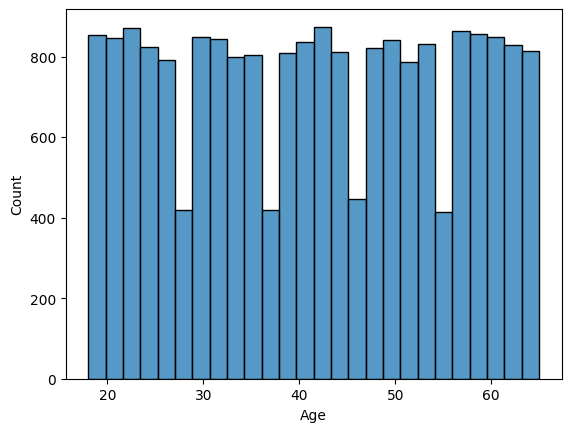

In [11]:
sns.histplot(data=df, x="Age")

In [12]:
# Standarize for training set
age_column = df['Age'].values.reshape(-1, 1)
scaler = StandardScaler()

df['Age'] = scaler.fit_transform(age_column)

# Standarize for testing set
age_column = df_test['Age'].values.reshape(-1, 1)
scaler = StandardScaler()

df_test['Age'] = scaler.fit_transform(age_column)

###Dummy Coding

In [13]:
# Set binary variables with values 0 and 1

# Set 0 and 1 in training set
df = df.replace({'Yes': 1, 'No': 0})
df = df.replace({'Male': 1, 'Female': 0})
df = df.replace({'Urban': 1, 'Rural': 0})

# Set 0 and 1 in testing set
df_test = df_test.replace({'Yes': 1, 'No': 0})
df_test = df_test.replace({'Male': 1, 'Female': 0})
df_test = df_test.replace({'Urban': 1, 'Rural': 0})

In [14]:
# Dummy code training set
for col in df.select_dtypes(include = 'object'):
  if df[col].nunique() > 2:
    df = pd.get_dummies(df, columns = [col])

# Dummy code testing set
for col in df_test.select_dtypes(include = 'object'):
  if df_test[col].nunique() > 2:
    df_test = pd.get_dummies(df_test, columns = [col])

In [15]:
# Turn object type features into numerical if they did not experience dummy coding
two_option_cols = df.select_dtypes(include = 'object').columns
df[two_option_cols] = df[two_option_cols].astype(int)

two_option_cols = df_test.select_dtypes(include = 'object').columns
df_test[two_option_cols] = df_test[two_option_cols].astype(int)

df.describe().T.round(2)

ValueError: invalid literal for int() with base 10: 'Alcohol'

###Resampling: using SMOTE

Since the outcome in training data is hugely imbalanced, I will apply SMOTE method.

In [ ]:
X_train = df.loc[:, df.columns != 'Panic Disorder Diagnosis']
y_train = df['Panic Disorder Diagnosis']

print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 95715, 1: 4285})


In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({0: 95715, 1: 95715})


###Heatmap
* Those grid with correlation smaller than -0.20 are all one-hot variables. Ignore them.
* Other than those, no variable has colinearity.

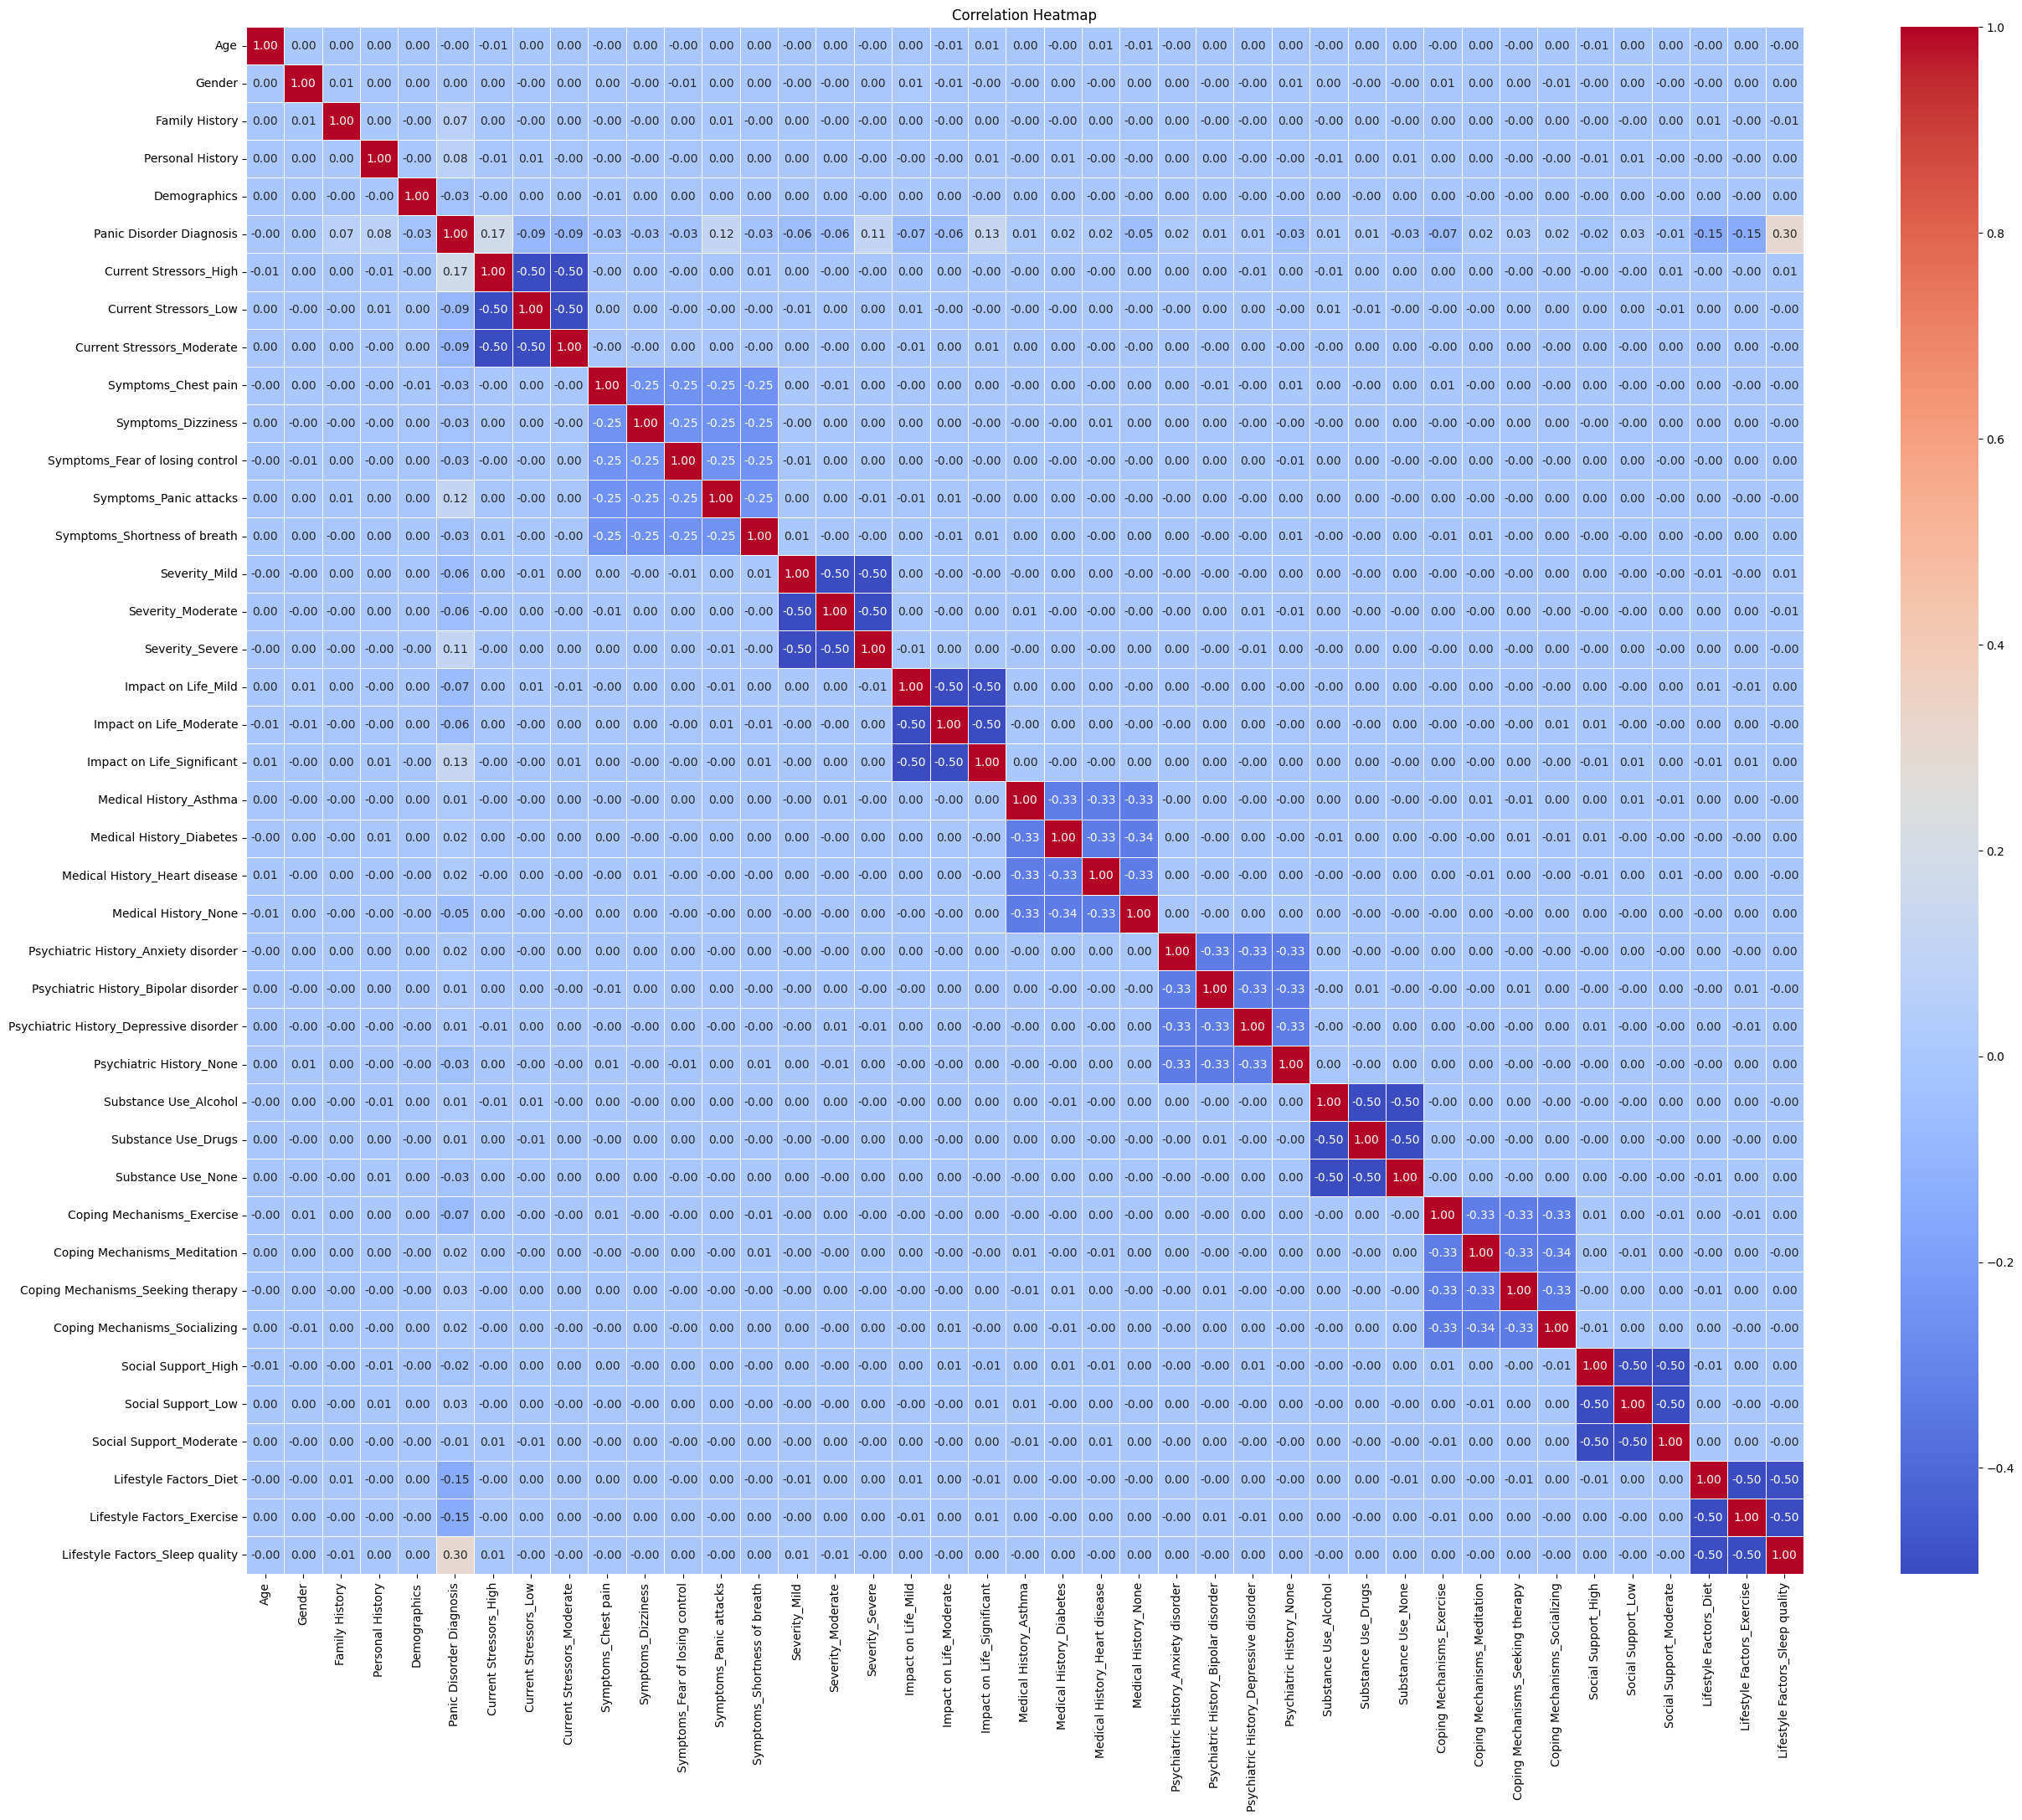

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap with correlation values
plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

***
## Analyses and Visualizations


In [ ]:
X_test = df_test.loc[:, df_test.columns != 'Panic Disorder Diagnosis']
y_test = df_test['Panic Disorder Diagnosis']

###Logistic Regression: Base Model

In [ ]:
model = LogisticRegression(max_iter=3000).fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print("ROC-AUC score: " + str(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19159
           1       0.59      0.69      0.64       841

    accuracy                           0.97     20000
   macro avg       0.79      0.83      0.81     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC score: 0.9832022764128141


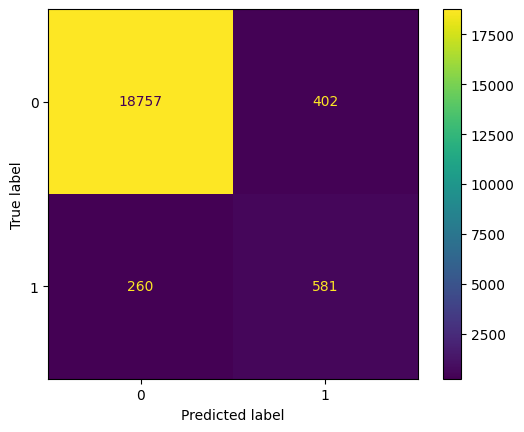

In [ ]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
# create parameter estimates
loglist = model.coef_.tolist()[0]
parameter_estimates = list(zip(X_train.columns, loglist))

#examine results
max_width = max(len(p[0]) for p in parameter_estimates)

for p in parameter_estimates:
    print (f'{p[0]:{max_width}}:    {round(p[1],3)}')
print()

Age                                    :    -0.032
Gender                                 :    -0.435
Family History                         :    0.859
Personal History                       :    0.992
Demographics                           :    -1.004
Current Stressors_High                 :    -2.391
Current Stressors_Low                  :    -5.679
Current Stressors_Moderate             :    -5.794
Symptoms_Chest pain                    :    -5.812
Symptoms_Dizziness                     :    -5.7
Symptoms_Fear of losing control        :    -5.618
Symptoms_Panic attacks                 :    -2.921
Symptoms_Shortness of breath           :    -5.601
Severity_Mild                          :    -5.615
Severity_Moderate                      :    -5.503
Severity_Severe                        :    -3.228
Impact on Life_Mild                    :    -5.907
Impact on Life_Moderate                :    -5.89
Impact on Life_Significant             :    -3.268
Medical History_Asthma              

**Warning:** since the dataset was originally highly imbalanced, the ROC-AUC curve is too close to the left upper corner.
* Accoding to the curve below, the more panic disorder patients are correctly identified (true positive), the more healthy people are categorized as panic disorder (false positive). And even small amount of increase in identifying real patients will result in a large amout of increase in false positive.

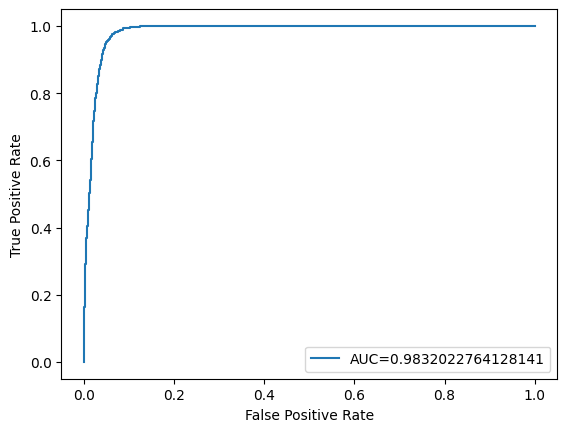

In [ ]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Ridge Regression

* Ridge regression will deal with colinearity and change the weight of each factor.

#### Choose C = 0.001 (alpha = 1000)

In [ ]:
model = LogisticRegression(penalty='l2', C=0.001, max_iter=3000).fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print("ROC-AUC score: " + str(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     19159
           1       0.39      0.99      0.56       841

    accuracy                           0.93     20000
   macro avg       0.69      0.96      0.76     20000
weighted avg       0.97      0.93      0.95     20000

ROC-AUC score: 0.9813837130778487


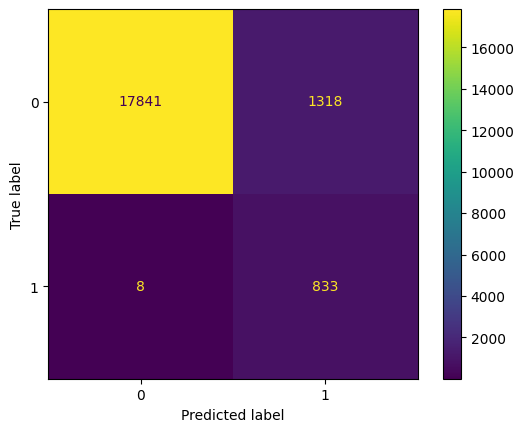

In [ ]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

**Warning:**
High false positive can be a terrible case for diagnosis. For diagnosis, it is WORSE to categorize a health person into a patient than fail to diagnose patients. We don't want to apply treatments to healthy people.
* Also, the dataset do not have hundered of features to cut off. It's affordable to run the full model rather than sacrificing accuracy. Patients' lives are more important.

This is a terrible case because we diagnoses more healthy people into patients. That is more serious than diagnozing more true positive cases.

In [ ]:
# create parameter estimates
loglist = model.coef_.tolist()[0]
parameter_estimates = list(zip(X_train.columns, loglist))

#examine results
max_width = max(len(p[0]) for p in parameter_estimates)

for p in parameter_estimates:
    print (f'{p[0]:{max_width}}:    {round(p[1],3)}')
print()

Age                                    :    -0.002
Gender                                 :    -0.291
Family History                         :    0.324
Personal History                       :    0.375
Demographics                           :    -0.552
Current Stressors_High                 :    1.026
Current Stressors_Low                  :    -0.932
Current Stressors_Moderate             :    -0.975
Symptoms_Chest pain                    :    -0.742
Symptoms_Dizziness                     :    -0.715
Symptoms_Fear of losing control        :    -0.703
Symptoms_Panic attacks                 :    0.873
Symptoms_Shortness of breath           :    -0.702
Severity_Mild                          :    -0.833
Severity_Moderate                      :    -0.773
Severity_Severe                        :    0.593
Impact on Life_Mild                    :    -0.865
Impact on Life_Moderate                :    -0.826
Impact on Life_Significant             :    0.647
Medical History_Asthma               

Features are treated more "equally".

#### Choose C=100 (alpha = 0.01)
This step makes large beta even larger. It will not increase the number of real patients being diagnosis, but will decrease the number of healthy people being wrongly diagnosed, which is a better model.

In [ ]:
model = LogisticRegression(penalty='l2', C=100, max_iter=3000).fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
print("ROC-AUC score: " + str(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19159
           1       0.60      0.69      0.64       841

    accuracy                           0.97     20000
   macro avg       0.79      0.83      0.81     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC score: 0.9832221364997429


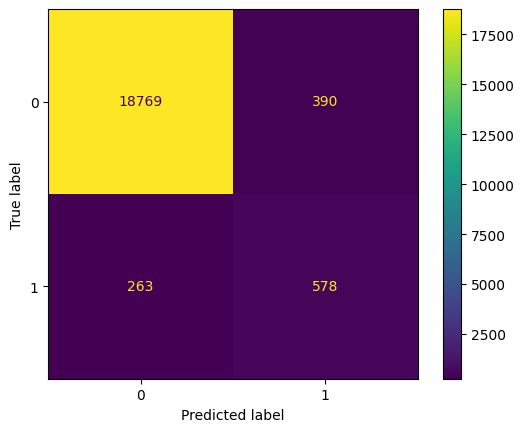

In [ ]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
# create parameter estimates
loglist = model.coef_.tolist()[0]
parameter_estimates = list(zip(X_train.columns, loglist))

#examine results
max_width = max(len(p[0]) for p in parameter_estimates)

for p in parameter_estimates:
    print (f'{p[0]:{max_width}}:    {round(p[1],3)}')
print()

Age                                    :    -0.036
Gender                                 :    -0.438
Family History                         :    0.906
Personal History                       :    1.057
Demographics                           :    -1.019
Current Stressors_High                 :    -6.575
Current Stressors_Low                  :    -9.906
Current Stressors_Moderate             :    -10.029
Symptoms_Chest pain                    :    -9.8
Symptoms_Dizziness                     :    -9.681
Symptoms_Fear of losing control        :    -9.593
Symptoms_Panic attacks                 :    -6.888
Symptoms_Shortness of breath           :    -9.572
Severity_Mild                          :    -9.587
Severity_Moderate                      :    -9.477
Severity_Severe                        :    -7.184
Impact on Life_Mild                    :    -9.963
Impact on Life_Moderate                :    -9.952
Impact on Life_Significant             :    -7.284
Medical History_Asthma            

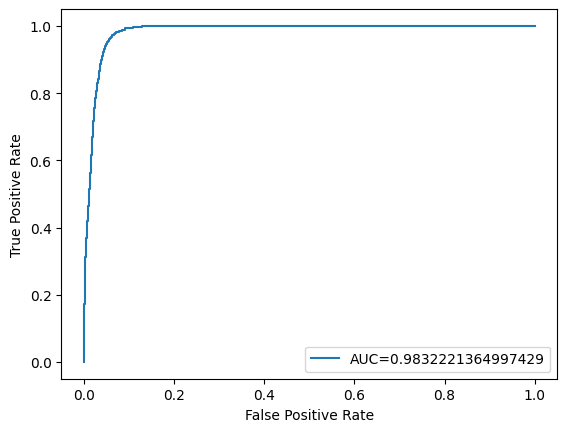

In [ ]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

###Lasso Regression

Note: large C (low alpha) did not make any feature into 0. I choose small C instead to cut down more features.

In [ ]:
model = LogisticRegression(penalty='l1', C=0.001, solver='saga', random_state=42).fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     19159
           1       0.32      1.00      0.49       841

    accuracy                           0.91     20000
   macro avg       0.66      0.95      0.72     20000
weighted avg       0.97      0.91      0.93     20000



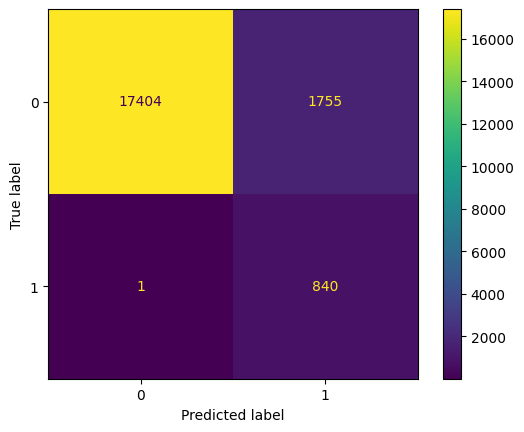

In [ ]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
# create parameter estimates
loglist = model.coef_.tolist()[0]
parameter_estimates = list(zip(X_train.columns, loglist))

#examine results
max_width = max(len(p[0]) for p in parameter_estimates)

for p in parameter_estimates:
    print (f'{p[0]:{max_width}}:    {round(p[1],3)}')
print()

Age                                    :    0.0
Gender                                 :    -0.094
Family History                         :    0.171
Personal History                       :    0.223
Demographics                           :    -0.476
Current Stressors_High                 :    1.661
Current Stressors_Low                  :    -0.735
Current Stressors_Moderate             :    -0.785
Symptoms_Chest pain                    :    -0.004
Symptoms_Dizziness                     :    0.0
Symptoms_Fear of losing control        :    0.0
Symptoms_Panic attacks                 :    1.868
Symptoms_Shortness of breath           :    0.0
Severity_Mild                          :    -0.631
Severity_Moderate                      :    -0.535
Severity_Severe                        :    0.919
Impact on Life_Mild                    :    -0.715
Impact on Life_Moderate                :    -0.651
Impact on Life_Significant             :    0.931
Medical History_Asthma                 :    0.0
M

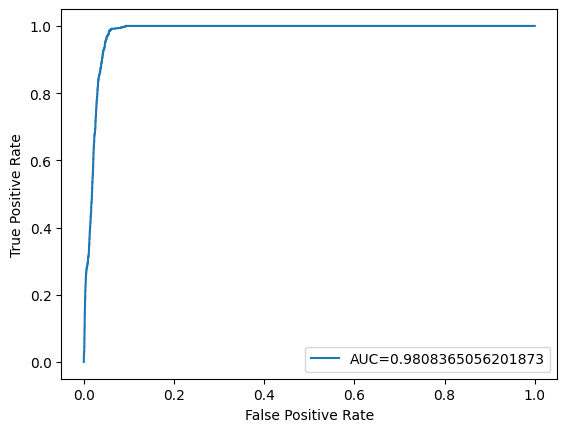

In [ ]:
#define metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

***
## Conclusions
* Logistic Regression model cannot replace real psychiatrists to diagnose panic disorder. Reduce the number of features can be even worse becase it will increase the number of healthy people being diagnosed into a panic disorder patient (false positive).
* Using small C in ridge regression model can make more true positive (more real patients being diagnosed) but will also increase the number of false positive, while small penalty does the opposite. At least C=100 will prevent healthy beings receiving treatments, and it is a better model if priority of the model is to keep people "safe" than discovering more patients.
* The most important three features of panic disorders are: Current Stressors_High, Symptoms_Panic attacks, Lifestyle Factors_Sleep quality. However, the reason of "Lifestyle Factors_Sleep quality" being the most important factor can be because those participants who chose "sleep quality" thinks that exercise and diet are less important rather than sleep quality itself is a negative life factor.
* The limitation of the research are:
1. most features are from dummy coding, and thus the effect of ridge regression does not work well.
2. The dataset is highly imbalanced, and thus the trade-off between True Positive and False Positive is too large. The curve does not come out to be a nice indicator of model.
